In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Character recognition model training

This notebook is used to train a model to recognize handwritten characters present in standard chess notation, which is :
- UCI <startCase><endCase> (in the form g1f3)
- SAN <PieceLetter?><endCase> (in the form Nf3)
- French SAN (same as SAN, but the PieceLetter differs) (in the form Cf3).

## Data

The data is stored in the `curated` folder, with each subfolder corresponding to a character. The images are 64x64 pixels, and the model is trained on these images.

We load only the characters we are interested in, here the 30 characters that are present in the UCI notation, the SAN notation and the French SAN notation.

Here are the characters we are interested in :
- a, b, c, d, e, f, g, h (for rows)
- 1, 2, 3, 4, 5, 6, 7, 8 (for columns)
- x (for captures)
- R, D, T, F, C (for French SAN pieces)
- K, Q, R, B, N (for SAN pieces)
- \+ (for checks)
- 0, - (for castlings)
- = (for promotions)
- \# (for checkmates)

The only one we exclude from the above list is the "C" character, which has too much overlap with the "c" character, and is thus not included.

In [4]:
# toLookChars = "abc"
toLookChars = "abcdefghxRDTFKNBQ123456780+-=#"

data = []
labels = []
maxSize = 0
for i, l in enumerate(os.listdir("curated")):
	if l == ".gitkeep":
		continue
	if chr(int(l)) in toLookChars:
		maxSize = max(maxSize, len(os.listdir(os.path.join("curated", l))))
		tmpD = []
		for f in os.listdir(os.path.join("curated", l)):
			img = Image.open(os.path.join("curated", l, f))
			img = img.resize((64, 64))
			img = np.array(img)
			img = img.reshape(-1)
			tmpD.append(img)
		labels.append(chr(int(l)))
		data.append(tmpD)

---
## Data augmentation

We want to have the same number of images for each character, so we augment the data by slightly translating the images for the characters that have less than the maximum number of images, here for example the "+" character, which has 30 times fewer images than the "e" character.

In [5]:
for i in range(len(data)):
	print(labels[i], len(data[i]))

d 1074
e 2962
f 608
g 760
h 990
x 463
# 152
+ 146
- 447
0 1103
1 1036
2 1056
3 1047
4 1028
5 957
6 943
7 1031
8 1055
= 254
B 505
D 553
F 486
K 508
N 689
Q 413
R 816
T 738
a 2219
b 624
c 880


In [6]:
# If there is less than the max size for any character, we add more by translating the image
dataPrim = [d[:] for d in data]
for i in range(len(data)):
	for j in range(maxSize - len(data[i])):
		img = Image.fromarray(data[i][j % len(data[i])].reshape(64, 64), 'L')
		img = img.transform((64, 64), Image.AFFINE, (1, 0, np.random.randint(-2, 2), 0, 1, np.random.randint(-2, 2)))
		img = np.array(img)
		img = img.reshape(-1)
		dataPrim[i].append(img)

In [7]:
for i in range(len(dataPrim)):
	print(labels[i], len(dataPrim[i]))

d 2962
e 2962
f 2962
g 2962
h 2962
x 2962
# 2962
+ 2962
- 2962
0 2962
1 2962
2 2962
3 2962
4 2962
5 2962
6 2962
7 2962
8 2962
= 2962
B 2962
D 2962
F 2962
K 2962
N 2962
Q 2962
R 2962
T 2962
a 2962
b 2962
c 2962


---
## Data preparation

We prepare the data for the training by creating the X and y arrays, where X is the images and y is the corresponding label.
We then split the data into a training and a testing set. We use 80% of the data for training and 20% for testing.

In [8]:
# Prepare the dataset for the training
X = []
y = []
for i in range(len(dataPrim)):
	for j in range(len(dataPrim[i])):
		X.append(dataPrim[i][j])
		y.append(labels[i])

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---
## Model creation

We create a simple neural network model using the `MLPClassifier` class from the `sklearn.neural_network` module. We use 3 hidden layers of 100 neurons each, and we train the model for 500 iterations. We use the `sgd` solver, which is the stochastic gradient descent, and we set the `verbose` parameter to 10 to see the progress of the training. We also set the `tol` parameter to a very low value to make sure the training stops only when the loss is very low, meaning the model will fit the data as much as possible.

In [9]:
# Create the model using sklearn and scikit-learn
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10, tol=0.00000001)

---
## Model training

We train the model using the training data. Here it took 95 iterations to train the model.

In [10]:
# Train the model
clf.fit(X_train, y_train)

Iteration 1, loss = 2.73205926
Iteration 2, loss = 1.32181992
Iteration 3, loss = 1.00233703
Iteration 4, loss = 0.84816794
Iteration 5, loss = 0.74741450
Iteration 6, loss = 0.67474585
Iteration 7, loss = 0.61509282
Iteration 8, loss = 0.56652566
Iteration 9, loss = 0.52646010
Iteration 10, loss = 0.49210921
Iteration 11, loss = 0.46084081
Iteration 12, loss = 0.43266008
Iteration 13, loss = 0.40967285
Iteration 14, loss = 0.38728506
Iteration 15, loss = 0.36440147
Iteration 16, loss = 0.34737189
Iteration 17, loss = 0.33133673
Iteration 18, loss = 0.31346782
Iteration 19, loss = 0.29935096
Iteration 20, loss = 0.28438933
Iteration 21, loss = 0.27404024
Iteration 22, loss = 0.25920454
Iteration 23, loss = 0.24598654
Iteration 24, loss = 0.23520944
Iteration 25, loss = 0.22643366
Iteration 26, loss = 0.21759915
Iteration 27, loss = 0.20541365
Iteration 28, loss = 0.19929366
Iteration 29, loss = 0.19300507
Iteration 30, loss = 0.18285582
Iteration 31, loss = 0.17503663
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, solver='sgd',
              tol=1e-08, verbose=10)

---
## Model evaluation

We evaluate the model using the testing data. The accuracy is 85.19%, which is quite good. We also show the confusion matrix to see which characters are the most often confused. It seems that the missing accuracy comes from sporadic confusions between a few characters, but overall the model does a good job at classifying the characters.

In [11]:
# Test the model
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8524645509790681


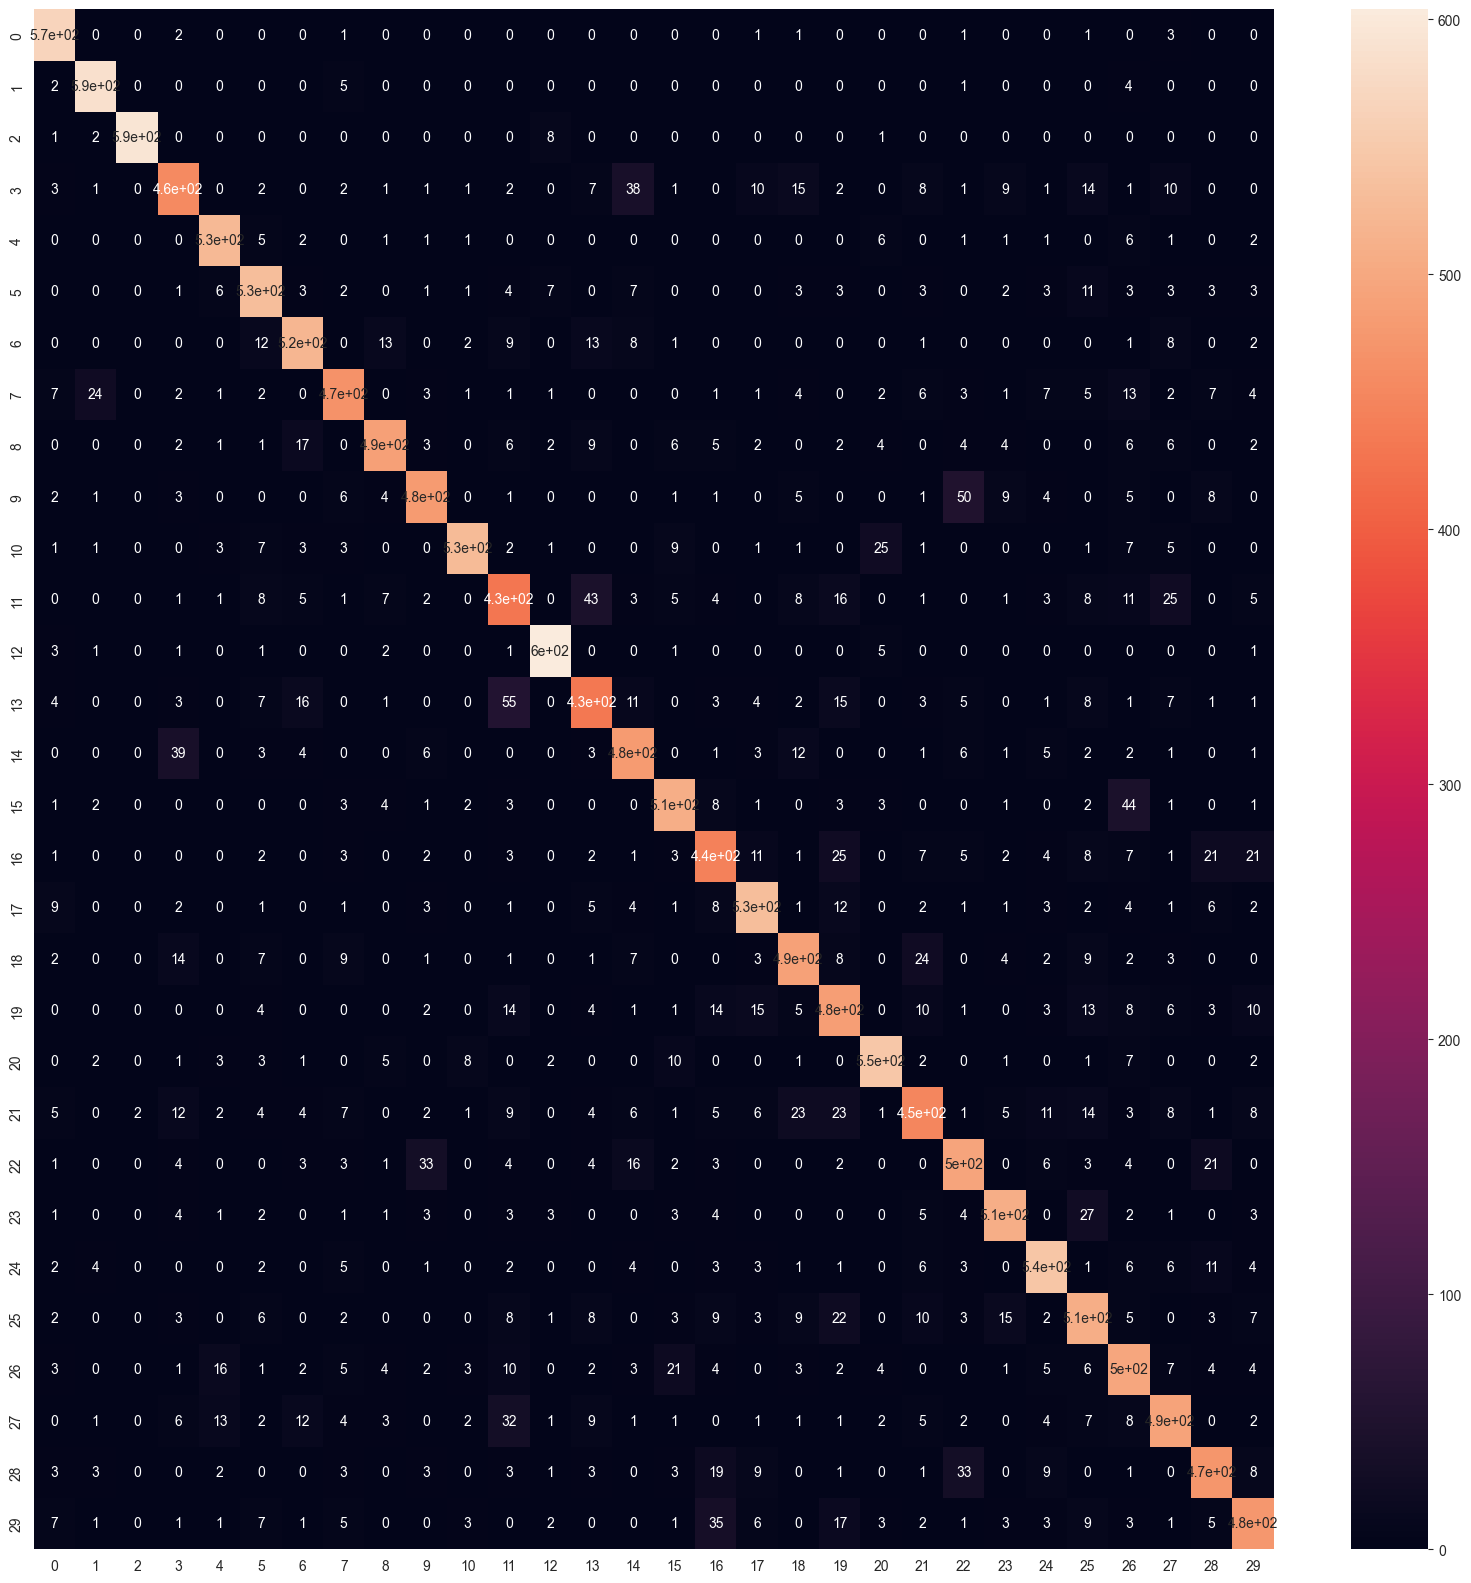

In [12]:
# Show the accuracy matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True)
plt.show()

---
Just to be sure, we also show which characters are the most often confused. We see that it is confused for the pairs "B"/"8", "6"/"b", "F"/"f" and "D"/"0". This is not surprising, as these characters are quite similar in shape when handwritten.

In [23]:
# Find the 4 most wrong predictions
wrong = {}
wrongIdx = []
for i in range(len(y_test)):
	if y_test[i] != y_pred[i]:
		wrongIdx.append(i)
		if y_test[i] + y_pred[i] not in wrong:
			wrong[y_test[i] + y_pred[i]] = 0
		wrong[y_test[i] + y_pred[i]] += 1
wl = list(wrong.items())
wl.sort(key=lambda x: x[1], reverse=True)
wl = [w for w in wl if w[1] >= 10]
print(wl)

[('B8', 55), ('6b', 50), ('Ff', 44), ('8B', 43), ('D0', 39), ('0D', 38), ('xK', 35), ('hb', 33), ('b6', 33), ('g8', 32), ('ce', 27), ('KR', 25), ('8g', 25), ('7T', 25), ('Qa', 24), ('4+', 24), ('aR', 23), ('aQ', 23), ('eR', 22), ('Kh', 21), ('fF', 21), ('bh', 21), ('Kx', 21), ('hK', 19), ('xR', 17), ('53', 17), ('bD', 16), ('B3', 16), ('8R', 16), ('f1', 16), ('BR', 15), ('ec', 15), ('RN', 15), ('0Q', 15), ('RK', 14), ('ae', 14), ('R8', 14), ('0e', 14), ('Q0', 14), ('Re', 13), ('4f', 13), ('3B', 13), ('g1', 13), ('35', 13), ('NR', 12), ('32', 12), ('DQ', 12), ('g3', 12), ('a0', 12), ('8f', 11), ('BD', 11), ('ad', 11), ('KN', 11), ('dh', 11), ('2e', 11), ('f8', 10), ('TF', 10), ('0N', 10), ('Rx', 10), ('Ra', 10), ('ea', 10), ('0g', 10)]


---
We can also show the top 5 predictions for a random failed test image, with the label and the probability. We can see that the model does get the right label in the top 5 predictions most of the time. The probabilities are also quite high, which means the model is quite confident in its predictions. The image is also shown, and we can see that it is not very clear, which explains why the model failed to predict the right label.

Label:  a
Predictions:  ['R', 'e', 'K', 'a', 'Q']
Probabilities:  0.96719967 0.02650214 0.00596720 0.00028645 0.00002405


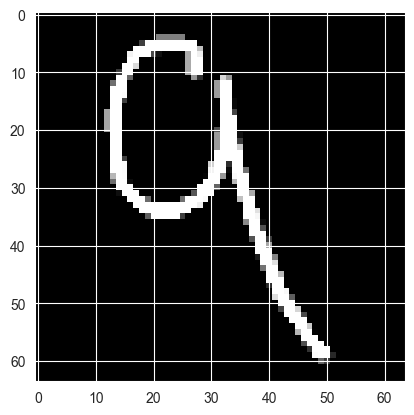

In [39]:
# Print which category corresponds to which index
labels = dict([(i, clf.classes_[i]) for i in range(len(clf.classes_))])

# Check the top 5 predictions for a random failed test image, with the label and the probability
idx = np.random.randint(0, len(wrongIdx))
print("Label: ", y_test[wrongIdx[idx]])
probas = clf.predict_proba(X_test[wrongIdx[idx]].reshape(1, -1))[0]
print("Predictions: ", [labels[v] for v in probas.argsort()[-5:][::-1]])
probas.sort()
print("Probabilities: ", *[f"{v:.8f}" for v in probas[-5:][::-1]])
# Show the image
plt.imshow(X_test[wrongIdx[idx]].reshape(64, 64), cmap='gray')
plt.show()

---
If needed, we can also save the model using the `pickle` module. We can then load the model using the `pickle.load` function in the characterPredicter module, and use it to predict the character depicted in an image.

In [ ]:
# Save model
# pickle.dump(clf, open("characterPredicter/model.sav", 'wb'))